In [1]:
import math
import numpy as np
import pandas as pd
import math
from scipy.stats import mode
from timeit import default_timer
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta
import pandas as pd
import sys

alpha:
  * creciente en a
  * decreciente en d
  
beta:
  * decreciente en a
  * creciente en d

In [21]:
balpha = lambda d,a: np.exp(1.0) + np.exp(a) - np.exp(d)
bbeta  = lambda d,a: np.exp(1.0) + np.exp(d) - np.exp(a)

In [22]:
n_values = 5
a_values = np.linspace(0, 1, n_values, endpoint=True)
d_values = np.linspace(0, 1, n_values, endpoint=True)

In [23]:
balpha(0, a_values)

array([2.71828183, 3.00230725, 3.3670031 , 3.83528185, 4.43656366])

In [24]:
balpha(d_values, 0)

array([2.71828183, 2.43425641, 2.06956056, 1.60128181, 1.        ])

In [25]:
bbeta(0, a_values)

array([2.71828183, 2.43425641, 2.06956056, 1.60128181, 1.        ])

In [26]:
bbeta(d_values, 0)

array([2.71828183, 3.00230725, 3.3670031 , 3.83528185, 4.43656366])

In [40]:
def generate_prob(D, c, e, h, k, n_values=5):

    # Discretization steps
    a_values = np.linspace(0, 1, n_values, endpoint=True)
    d_values = np.linspace(0, 1, n_values, endpoint=True)

    f = lambda d, theta: (1-theta)*D - c*d
    g = lambda a, theta: theta*D - e*a

    balpha = lambda d,a: np.exp(1.0) + np.exp(a) - np.exp(d)
    bbeta  = lambda d,a: np.exp(1.0) + np.exp(d) - np.exp(a)

    prob = lambda d, a, size=1: np.random.beta( balpha(d,a), bbeta(d,a), size=size )

    c1 = 1 - np.exp(-h*D)
    c2 = 1 - np.exp(h*c)

    e1 = np.exp(-k*D)
    e2 = np.exp(k*e)

    ##
    h1 =   1 / (c1 - c2)
    h2 = -c2 / (c1 - c2)

    k1 =   1 / (e1 - e2)
    k2 = -e2 / (e1 - e2)

    d_util = lambda d, theta: h1*(1.0 - np.exp( -h * f(d,theta) ) ) + h2
    a_util = lambda a, theta: k1*(np.exp(-k * g(a,theta) )) + k2

    return a_values, d_values, a_util, d_util, prob, balpha, bbeta

In [41]:
def plot_beta(balpha, bbeta, ax=None):
    mean = beta.stats(balpha, bbeta, moments='m')
    bx = np.linspace(beta.ppf(0.01, balpha, bbeta), beta.ppf(0.99, balpha, bbeta), 100)
    ax.plot(bx, beta.pdf(bx, balpha, bbeta), 'r-', lw=5, alpha=0.6)
    #ax.set_title("beta: alpha={:.2f}, beta={:.2f}\n mean={:.4f}".format(balpha, bbeta, mean))

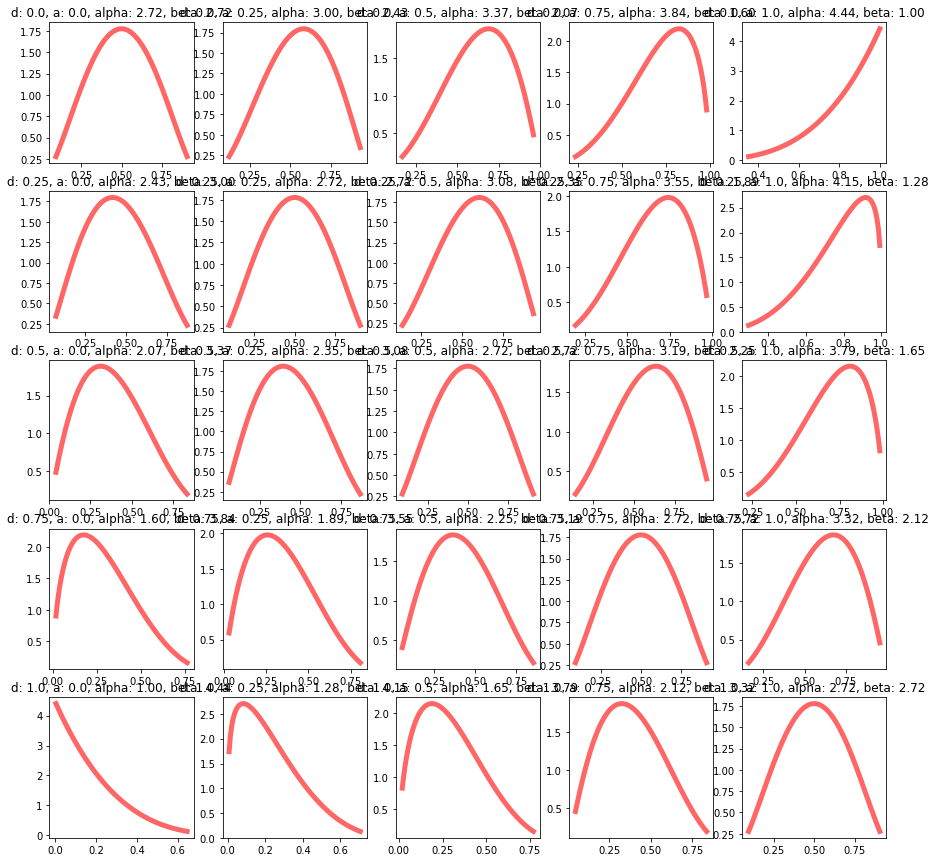

In [82]:
params = (1.0, 0.1, 0.1, 0.1, 100.0)
a_values, d_values, a_util, d_util, prob, balpha, bbeta = generate_prob(*params, n_values=5)

res = []
fig, ax = plt.subplots(len(d_values), len(a_values), figsize=(15, 15))
for i, d in enumerate(d_values):
    for j, a in enumerate(a_values):
        theta = prob(d, a, size=1000)
        res.append([d, a, balpha(d, a), bbeta(d, a), d_util(d, theta).mean(), a_util(a, theta).mean() ])
        plot_beta(balpha(d, a), bbeta(d, a), ax=ax[i, j])
        ax[i, j].set_title("d: {}, a: {}, alpha: {:.2f}, beta: {:.2f}".format(d, a, balpha(d, a), bbeta(d, a)))


df = pd.DataFrame(res, columns=['d', 'a', 'alpha', 'beta', 'd_util', 'a_util'])

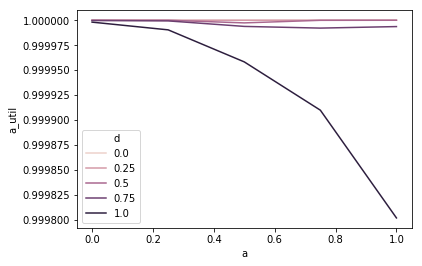

In [83]:
%matplotlib inline
import seaborn as sns

sns.lineplot(x='a', y='a_util', hue='d', data=df, legend='full');

In [61]:
def solve(d_given, a_values, prob, a_util, mcmc_iters=100000):
    psi_a = np.zeros(len(a_values), dtype=float)
    for j, a in enumerate(a_values):
        theta_a = prob(d_given, a, size=mcmc_iters)
        psi_a[j] = a_util(a, theta_a).mean()
    
    a_opt = a_values[psi_a.argmax()]
    return a_opt

In [73]:
from itertools import product

D_range = 10.0 ** np.array([-1, 0, 1, 2, 3])
c_range = 10.0 ** np.array([-1, 0, 1, 2, 3])
e_range = 10.0 ** np.array([-1, 0, 1, 2, 3])
h_range = 10.0 ** np.array([-1, 0, 1, 2, 3])
k_range = 10.0 ** np.array([-1, 0, 1, 2, 3])

grid = product(D_range, c_range, e_range, h_range, k_range)

res = []

for params in grid:
    a_values, d_values, a_util, d_util, prob, balpha, bbeta = generate_prob(*params, n_values=5)
    res.append(list(params) + [solve(0, a_values, prob, a_util), solve(1, a_values, prob, a_util)])

df1 = pd.DataFrame(res, columns=['D', 'c', 'e', 'h', 'k', 'a_opt0', 'a_opt1'])

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


In [74]:
df1['diff'] = np.abs(df1['a_opt0'] - df1['a_opt1'])

In [81]:
df1[df1['diff'] == 1].sort_values(['diff', 'D', 'c', 'e', 'h', 'k'], ascending=False)

,D,c,e,h,k,a_opt0,a_opt1,diff
3095,1000.0,1000.0,100.0,1000.0,0.1,1.0,0.0,1.0
3090,1000.0,1000.0,100.0,100.0,0.1,1.0,0.0,1.0
3047,1000.0,1000.0,1.0,1000.0,10.0,0.0,1.0,1.0
3042,1000.0,1000.0,1.0,100.0,10.0,0.0,1.0,1.0
3037,1000.0,1000.0,1.0,10.0,10.0,0.0,1.0,1.0
3032,1000.0,1000.0,1.0,1.0,10.0,0.0,1.0,1.0
3027,1000.0,1000.0,1.0,0.1,10.0,0.0,1.0,1.0
3022,1000.0,1000.0,0.1,1000.0,10.0,0.0,1.0,1.0
3017,1000.0,1000.0,0.1,100.0,10.0,0.0,1.0,1.0
3012,1000.0,1000.0,0.1,10.0,10.0,0.0,1.0,1.0


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/matplotlib-3.0.2-py3.6-linux-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


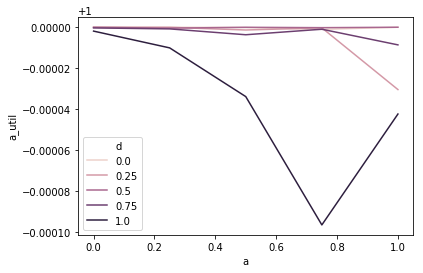

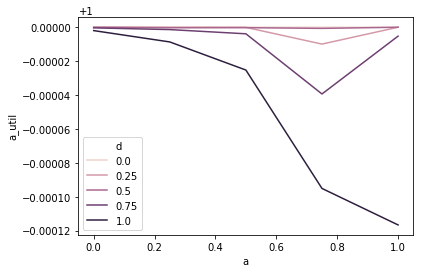

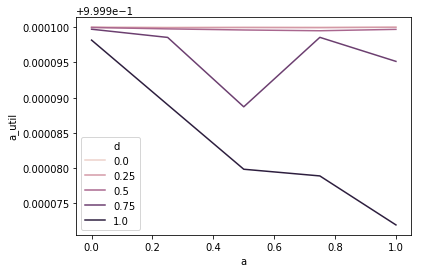

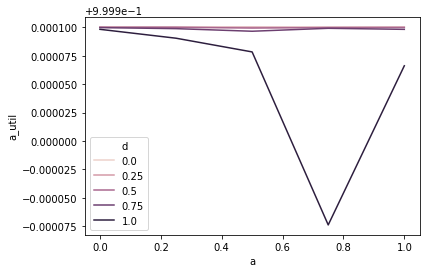

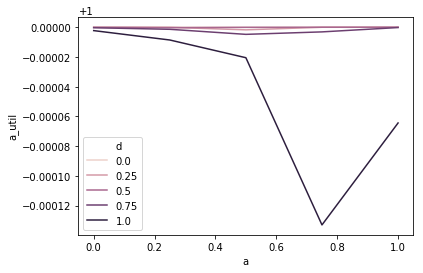

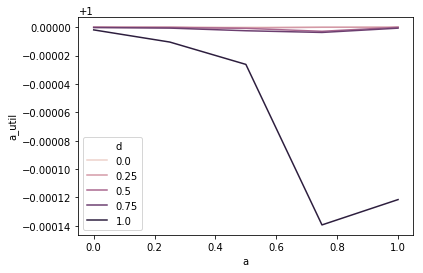

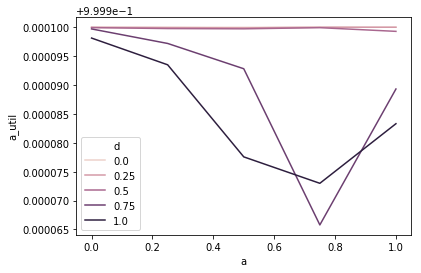

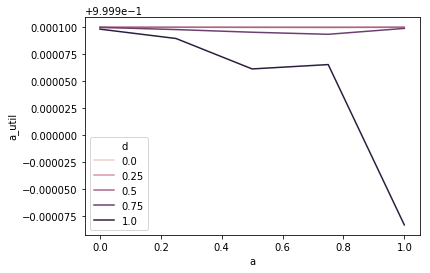

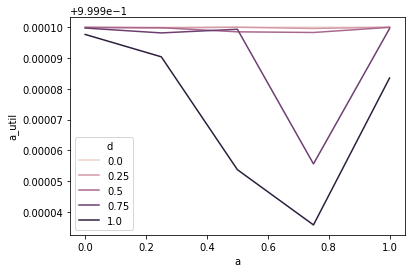

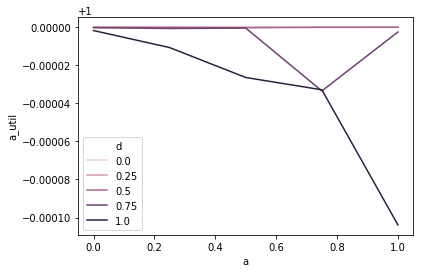

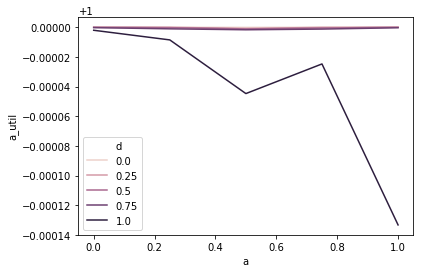

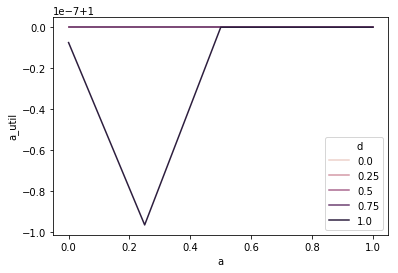

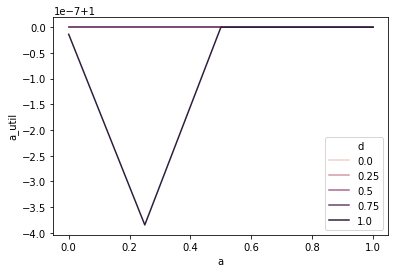

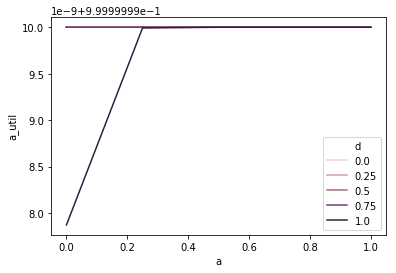

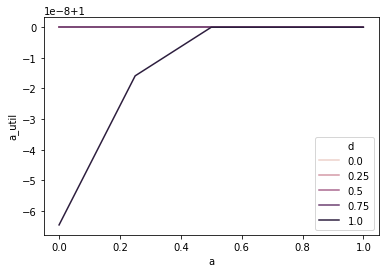

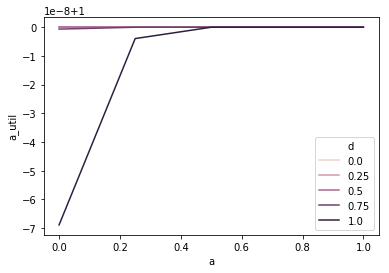

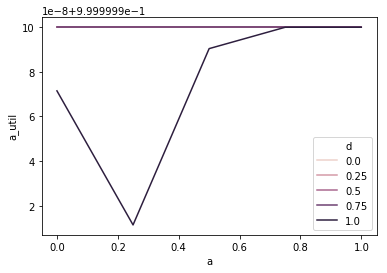

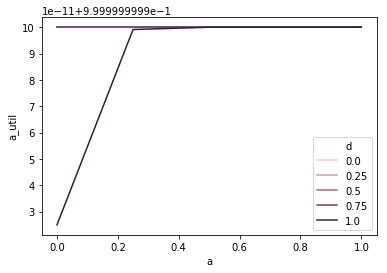

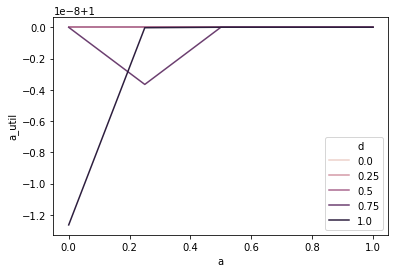

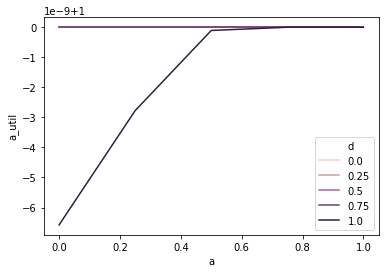

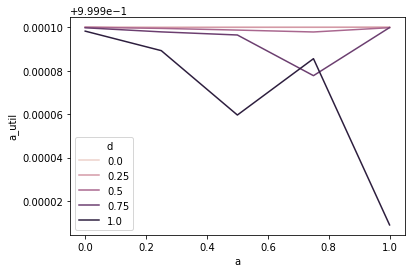

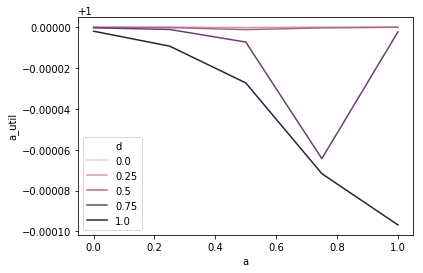

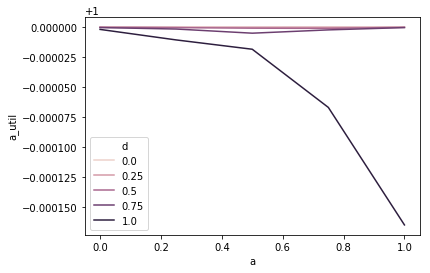

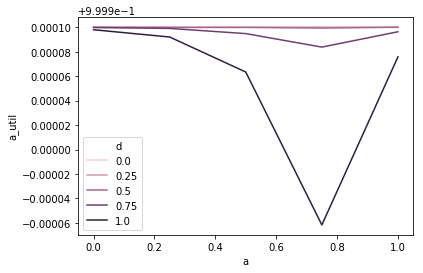

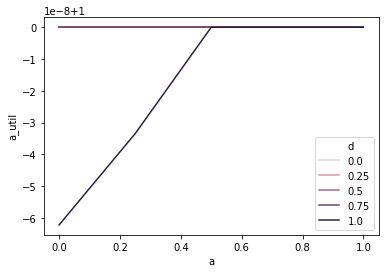

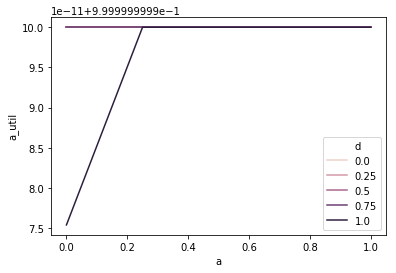

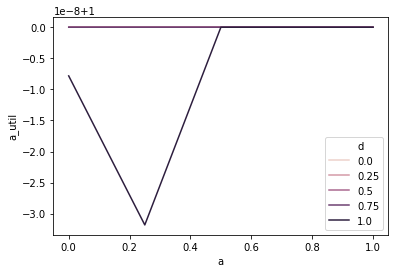

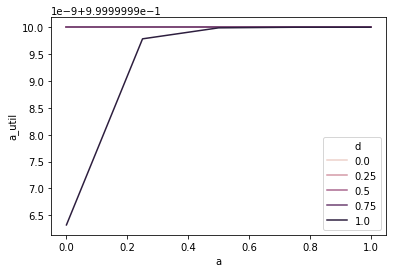

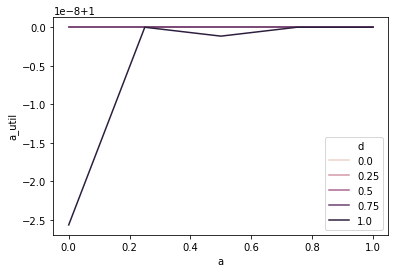

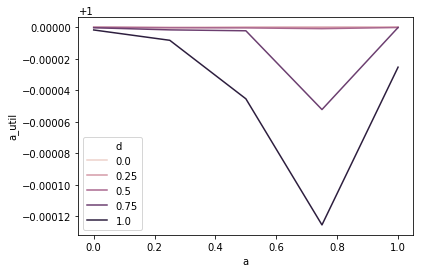

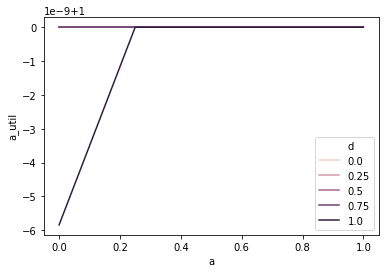

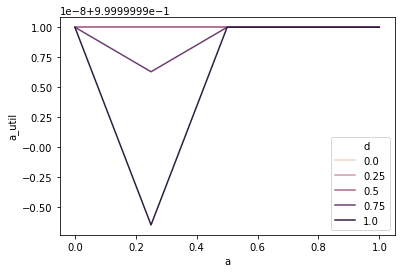

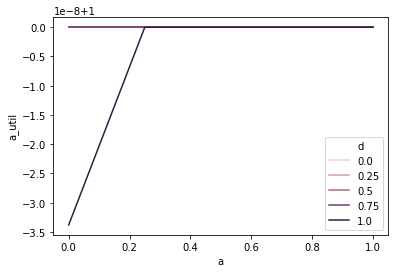

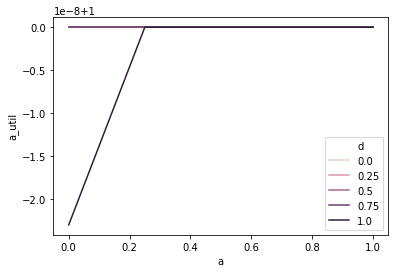

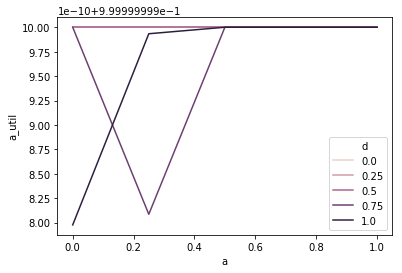

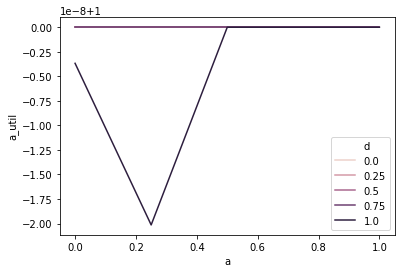

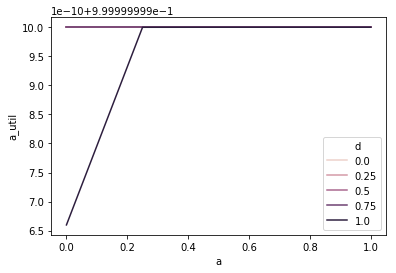

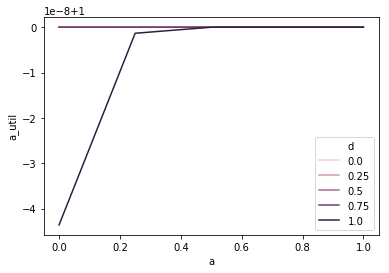

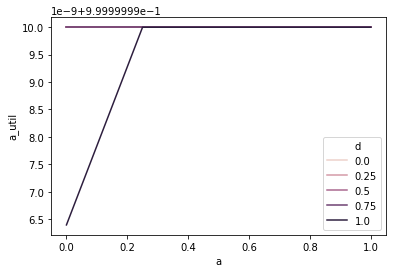

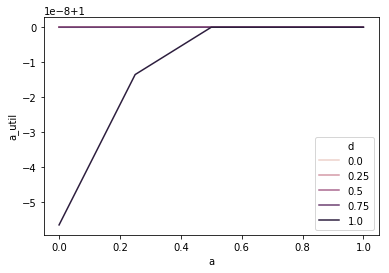

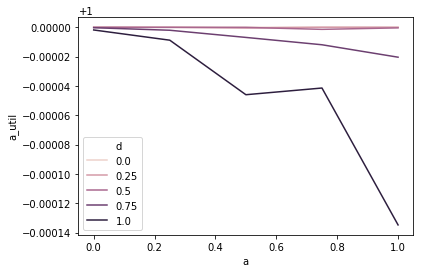

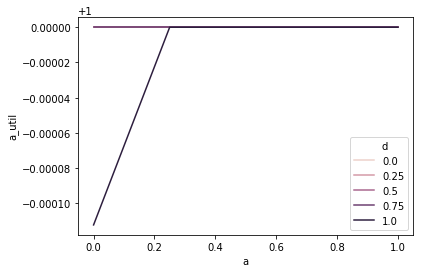

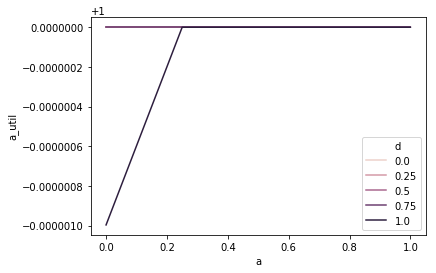

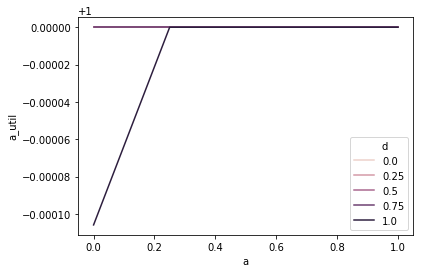

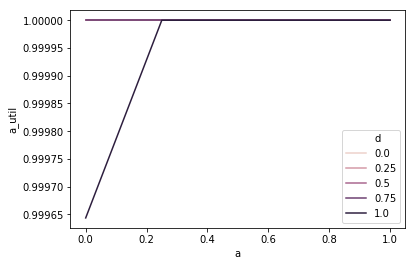

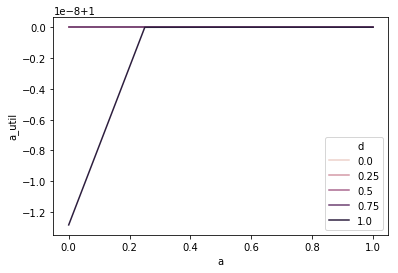

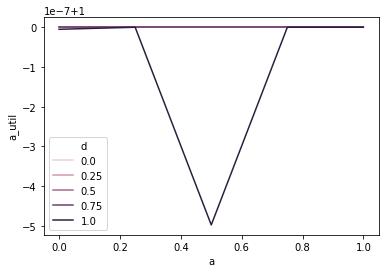

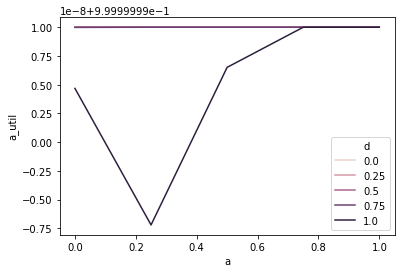

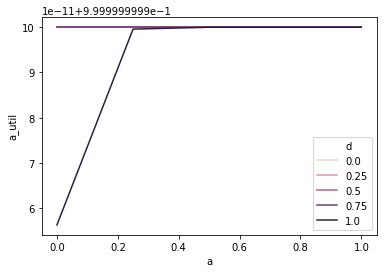

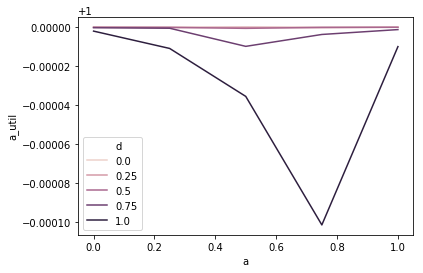

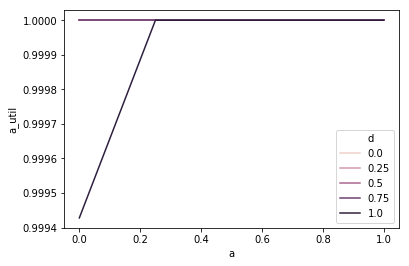

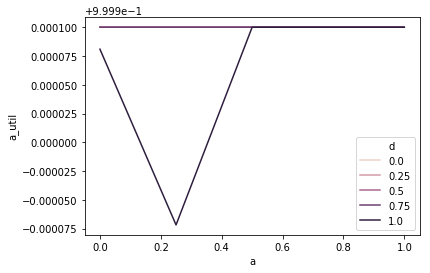

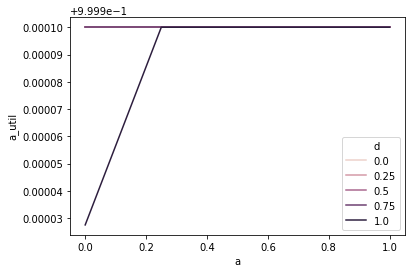

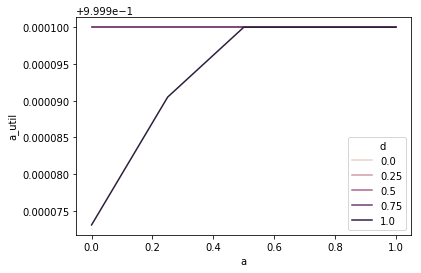

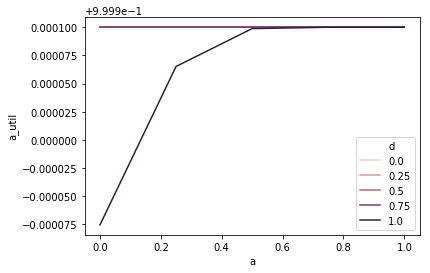

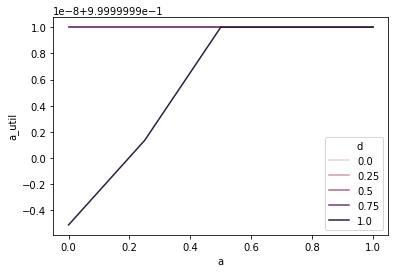

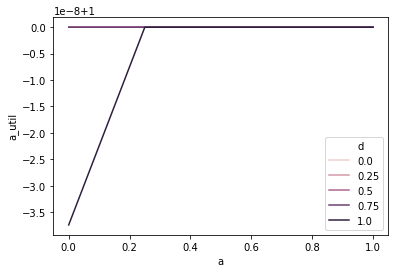

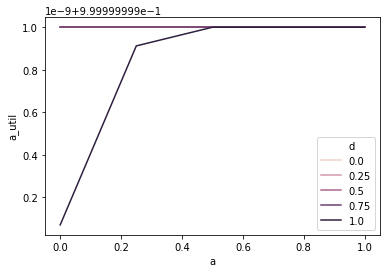

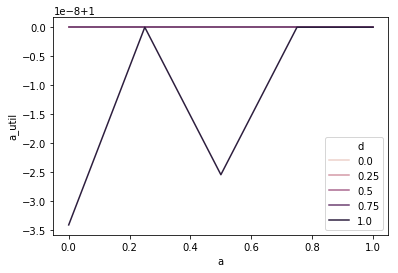

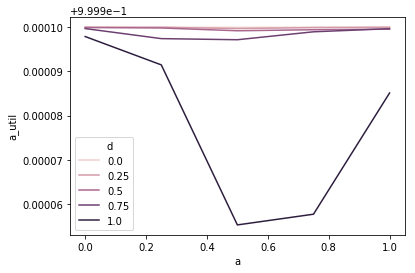

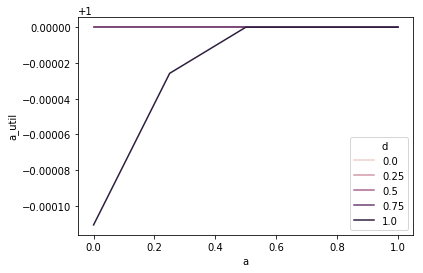

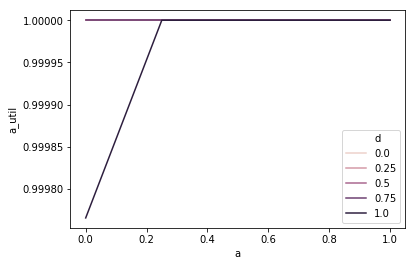

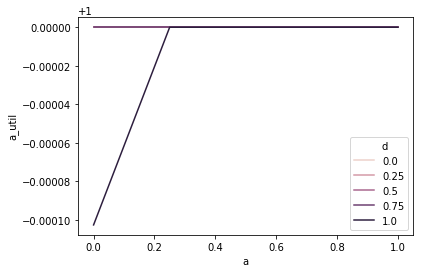

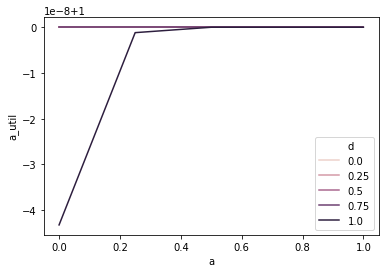

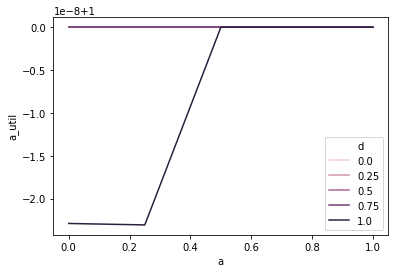

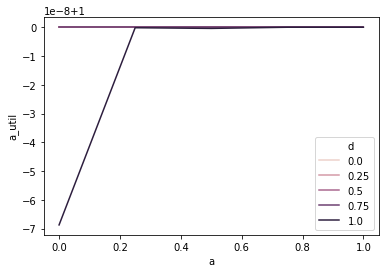

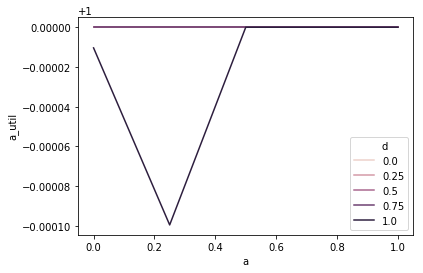

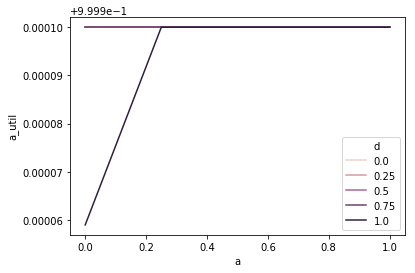

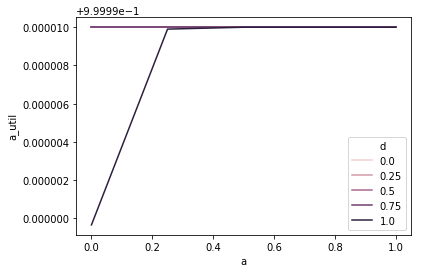

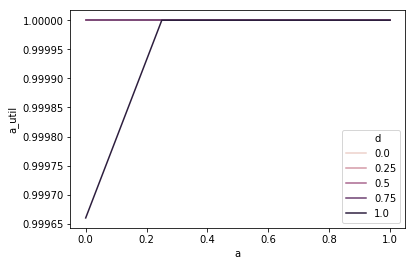

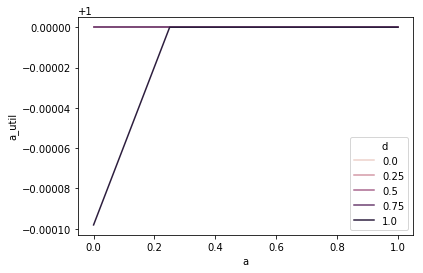

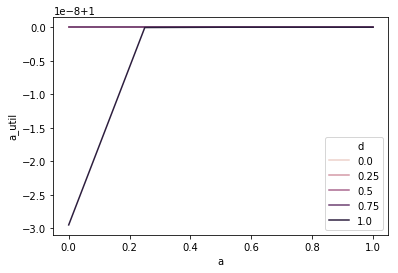

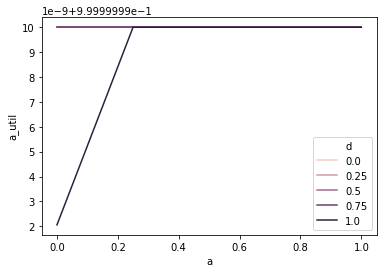

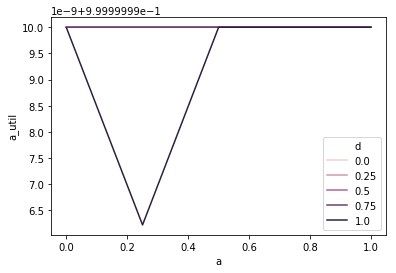

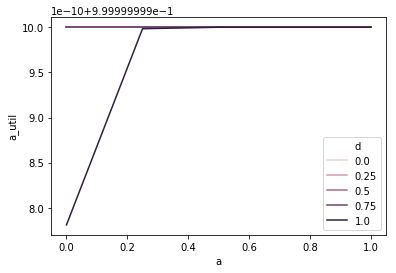

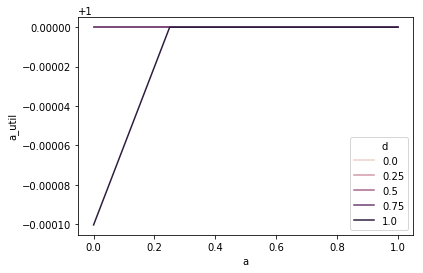

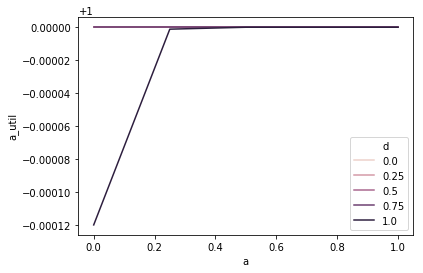

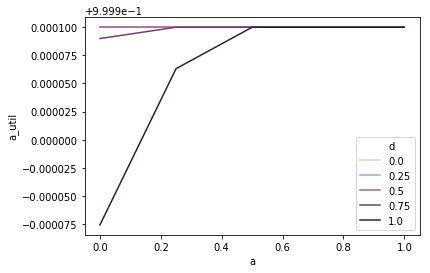

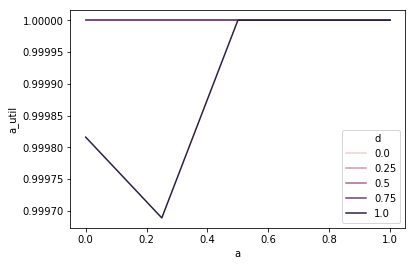

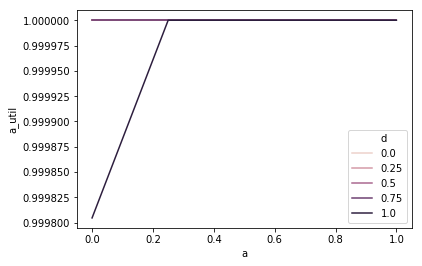

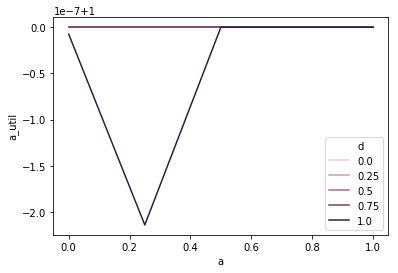

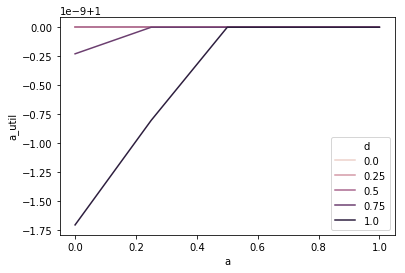

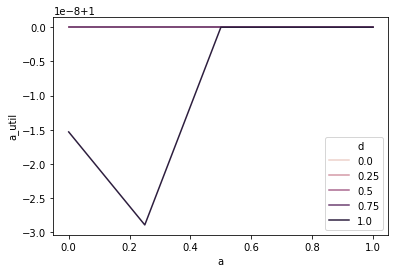

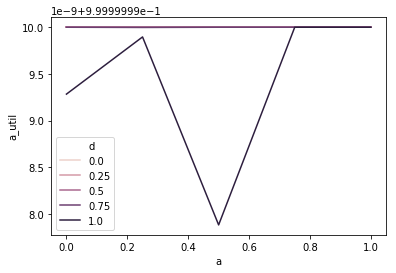

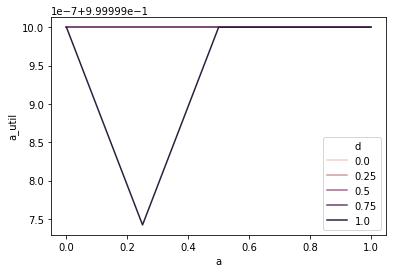

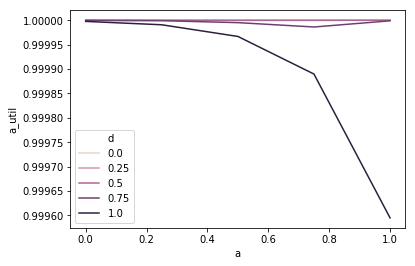

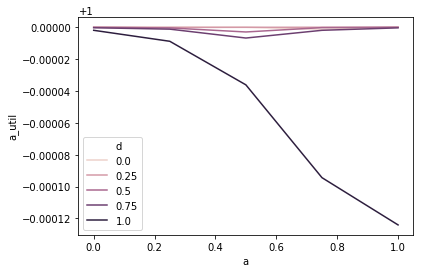

In [88]:
for params in df1.loc[df1['diff'] == 1, ['D', 'c', 'e', 'h', 'k']].itertuples(index=False):
    a_values, d_values, a_util, d_util, prob, balpha, bbeta = generate_prob(*params, n_values=5)

    res = []
    for i, d in enumerate(d_values):
        for j, a in enumerate(a_values):
            theta = prob(d, a, size=1000)
            res.append([d, a, balpha(d, a), bbeta(d, a), d_util(d, theta).mean(), a_util(a, theta).mean() ])

    df = pd.DataFrame(res, columns=['d', 'a', 'alpha', 'beta', 'd_util', 'a_util'])
    plt.figure()
    sns.lineplot(x='a', y='a_util', hue='d', data=df, legend='full');